# Übung 1: Berechnung einer absoluten Positionierung mit Code-Messungen

In [1]:
# Requirements 
# pip install git+https://github.com/GNSSpy-Project/gnsspy
# pip install pyunpack
# pip install georinex

import gnsspy as gp
import numpy as np
import georinex
import geopandas
import matplotlib.pyplot as plt
import math

In [37]:
# Dataimport
station = gp.read_obsFile("ONSA0320.11O")
ephemerides = georinex.load("G3_11032.PRE")

ONSA0320.11O exist in working directory | Reading...
Line 19 :                             4  4
Unexpected format between epochs! Line 20 is deleted!
Line 24 :                             4  4
Unexpected format between epochs! Line 25 is deleted!
Line 29 :                             4  4
Unexpected format between epochs! Line 30 is deleted!
Line 34 :                             4  4
Unexpected format between epochs! Line 35 is deleted!
Line 39 :                             4  4
Unexpected format between epochs! Line 40 is deleted!
Line 44 :                             4  4
Unexpected format between epochs! Line 45 is deleted!
Line 49 :                             4  4
Unexpected format between epochs! Line 50 is deleted!
Line 54 :                             4  4
Unexpected format between epochs! Line 55 is deleted!
Line 59 :                             4  4
Unexpected format between epochs! Line 60 is deleted!
Line 64 :                             4  4
Unexpected format between epoch

In [106]:
def calculateLatLong(earth_fixed_coords):
    lat = list()
    lon = list()

    for x, y, z in earth_fixed_coords:
        lat.append(math.atan2(z, math.sqrt(x**2 + y**2)) * 180/math.pi) 
        lon.append(math.atan2(y, x) * 180/math.pi)

    return lat, lon

def plotGroundTrack(name, desc, lat, lon):
    countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

    countries.plot(color = "grey")
    plt.scatter(lon, lat, color = "purple")

    minimum = min(lat)
    maximum = max(lat)

    plt.grid()
    plt.ylim(-90,90)
    plt.xlim(-180,180)
    plt.title(name + " " + desc)
    plt.figtext(0.5, 0.15, "Minimale Breite: " + str(minimum) + "° / maximale Breite: " + str(maximum) + "°", ha = "center", fontsize = 9, style = "italic")
    plt.show()
    #plt.savefig("Export/" + name + "_" + desc + '.png')

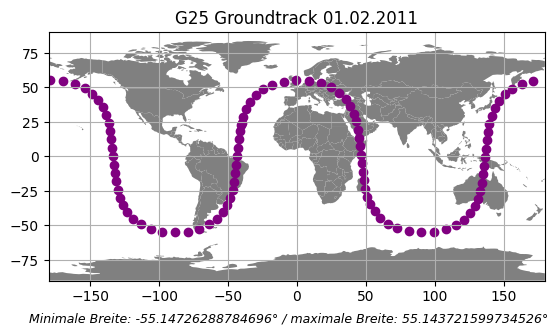

In [107]:
# Plot Groundtrack
earth_fixed_G25 = ephemerides.sel(sv="G25").position


lat, lon = calculateLatLong(earth_fixed_G25)
plotGroundTrack("G25", "Groundtrack 01.02.2011", lat, lon)
